In [26]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch import nn
import csv
import os
import scipy
import matplotlib.pyplot as plt

In [27]:
records = []
labels = []
recId2LabId = dict()

train_dir = 'training2017'
# mapa etykiet
label_map = {'N':0,'A':1,'O':2,'~':3}
inv_map = {0:'N',1:'A',2:'O',3:'~'}

# załadowanie etykiet	
labels_csv = os.path.join(train_dir, 'REFERENCE-v3.csv')
with open(labels_csv, newline='') as file:
	for row in csv.reader(file, delimiter=',', quotechar='|'):
		recId2LabId[row[0]] = label_map[row[1]]


In [28]:

# załadowanie danych
for filename in os.listdir(train_dir):
	if not filename.endswith('.mat'):
		continue

	f_path = os.path.join(train_dir, filename)
	record = scipy.io.loadmat(f_path)['val'][0]
	

	if len(record) >= 4096:
		# zapisy o długości minimum 4096, skracane do 2048
		records.append(record[:4096:2])
		labels.append(recId2LabId[filename[:-4]])

# print(records[0])


In [29]:
records = torch.from_numpy(np.stack(records)).type(torch.float)
records = torch.unsqueeze(records,-2)
labels = torch.tensor(labels)

print(records.shape)
print(labels.shape)

torch.Size([8240, 1, 2048])
torch.Size([8240])


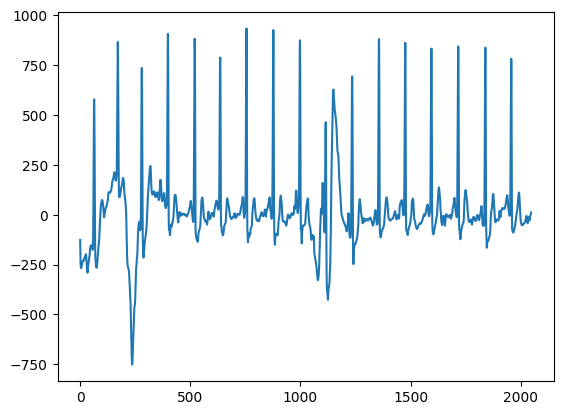

In [30]:
plt.plot(records[0,0])

In [31]:
# # normalizacja
# # records = (records - mean)/sd
# # print(records.dtype)
rec_mean = torch.mean(records, dim = 2, keepdim = True)
rec_sd = torch.std(records, dim = 2, keepdim = True)
records = (records - rec_mean)/rec_sd

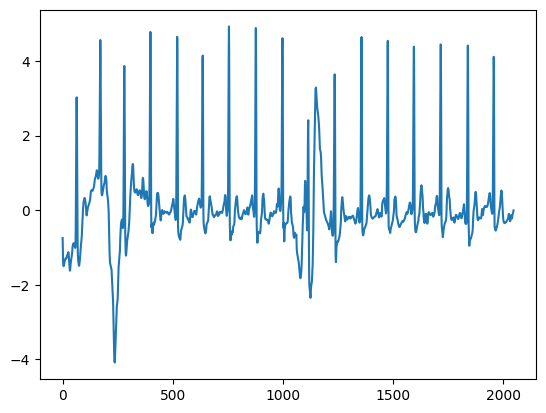

In [32]:
plt.plot(records[0,0])

In [33]:
ds = TensorDataset(records, labels)
train_ds, val_ds = random_split(ds, [int(len(ds)*0.8), len(ds) - int(len(ds)*0.8)])
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
model = nn.Sequential(
	nn.Conv1d(1,8,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Conv1d(8,16,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Conv1d(16,32,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Conv1d(32,64,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Conv1d(64,128,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Conv1d(128,256,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Flatten(),
	nn.Linear(32*256, 256),
	nn.ReLU(),
	nn.Linear(256,4)
).to(device)

In [43]:
optimizer = torch.optim.Adam(model.parameters(),1e-3)
loss_fn = nn.CrossEntropyLoss()

In [44]:
epochs = 10

for epoch in range(epochs):
	for X, y in train_dl:
		X = X.to(device)
		y = y.to(device)
		y_pred = model(X)
		loss = loss_fn(y_pred, y)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		print(loss.item())

1.3694281578063965
1.1633814573287964
0.9455644488334656
1.1433480978012085
1.0891830921173096
1.0364633798599243
0.9555011987686157
0.9929096698760986
1.0140868425369263
0.973210871219635
0.9985499382019043
1.0595312118530273
1.0972152948379517
1.1762549877166748
0.985359787940979
0.9860456585884094
1.0454847812652588
0.8972232937812805
0.7963149547576904
0.7748655676841736
0.9957805871963501
1.179617166519165
1.1438252925872803
1.0474568605422974
0.9749971628189087
0.9800533652305603
0.921394944190979
0.8398293256759644
0.907063901424408
0.9433512091636658
0.8634412288665771
0.8918638825416565
0.9635039567947388
0.8927211165428162
0.9458401799201965
1.3017425537109375
1.0832884311676025
1.0046433210372925
1.0805060863494873
1.0745116472244263
0.9691882133483887
1.0993258953094482
0.9584306478500366
0.9662129282951355
0.9182683229446411
0.8645462393760681
1.0515297651290894
0.961338996887207
0.8951303958892822
1.1393755674362183
0.96623694896698
1.0242338180541992
0.7886770367622375
0

In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np

def my_confusion_matrix(dataloader, classes):
    cm = np.zeros((classes, classes))
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y_pred = model(X).argmax(dim=1).cpu()
            cm += confusion_matrix(y, y_pred, labels=list(range(classes)))
    return cm.astype(int)

In [45]:
cm = my_confusion_matrix(val_dl, 4)
print(cm)

[[869  12  94  13]
 [ 28  65  48   0]
 [243  38 188   4]
 [ 18   0  18  10]]
